## 08-06 RNN을 이용한 텍스트 생성(Text Generation using RNN)

### RNN을 이용하여 텍스트 생성하기

예를 들어서 '경마장에 있는 말이 뛰고 있다'와 '그의 말이 법이다'와 '가는 말이 고와야 오는 말이 곱다'라는 세 가지 문장이 있다고 해봅시다. 모델이 문맥을 학습할 수 있도록 전체 문장의 앞의 단어들을 전부 고려하여 학습하도록 데이터를 재구성한다면 아래와 같이 총 11개의 샘플이 구성됩니다.  
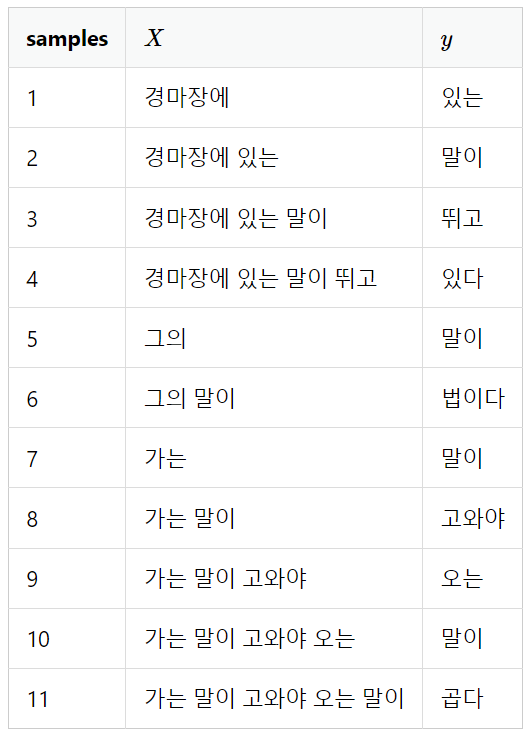

1. 데이터에 대한 이해와 전처리

In [39]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

text = """경마장에 있는 말이 뛰고 있다\n
그의 말이 법이다\n
가는 말이 고와야 오는 말이 곱다\n"""

tokenizer = Tokenizer()
tokenizer.fit_on_texts([text])
vocab_size = len(tokenizer.word_index) + 1 # 패딩 고려하여 +1
print('단어 집합의 크기: %d' % vocab_size) 
print('각 단어와 단어에 부여된 정수 인덱스:', tokenizer.word_index)

단어 집합의 크기: 12
각 단어와 단어에 부여된 정수 인덱스: {'말이': 1, '경마장에': 2, '있는': 3, '뛰고': 4, '있다': 5, '그의': 6, '법이다': 7, '가는': 8, '고와야': 9, '오는': 10, '곱다': 11}


In [40]:
sequences = list()
for line in text.split('\n'): # 줄바꿈 문자를 기준으로 문장 토큰화
    encoded = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(encoded)):
        sequence = encoded[:i+1]
        sequences.append(sequence)

print('학습에 사용할 샘플의 개수: %d' % len(sequences))
print('전체 샘플: ',sequences)

학습에 사용할 샘플의 개수: 11
전체 샘플:  [[2, 3], [2, 3, 1], [2, 3, 1, 4], [2, 3, 1, 4, 5], [6, 1], [6, 1, 7], [8, 1], [8, 1, 9], [8, 1, 9, 10], [8, 1, 9, 10, 1], [8, 1, 9, 10, 1, 11]]


In [41]:
# 가장 긴 샘플의 길이를 기준으로 전체 샘플의 길이를 일치시키기 위해 가장 긴 샘플의 길이 확인
max_len = max(len(l) for l in sequences) # 모든 샘플에서 길이가 가장 긴 샘플의 길이 출력
print('샘플의 최대 길이 : {}'.format(max_len))

샘플의 최대 길이 : 6


In [42]:
# 전체 샘플의 길이를 6으로 패딩
sequences = pad_sequences(sequences, maxlen=max_len, padding='pre')
print(sequences)

[[ 0  0  0  0  2  3]
 [ 0  0  0  2  3  1]
 [ 0  0  2  3  1  4]
 [ 0  2  3  1  4  5]
 [ 0  0  0  0  6  1]
 [ 0  0  0  6  1  7]
 [ 0  0  0  0  8  1]
 [ 0  0  0  8  1  9]
 [ 0  0  8  1  9 10]
 [ 0  8  1  9 10  1]
 [ 8  1  9 10  1 11]]


In [43]:
# 각 샘플의 마지막 단어를 레이블로 분리
sequences = np.array(sequences)
X = sequences[:,:-1]
y = sequences[:,-1]
print(X)
print(y)

[[ 0  0  0  0  2]
 [ 0  0  0  2  3]
 [ 0  0  2  3  1]
 [ 0  2  3  1  4]
 [ 0  0  0  0  6]
 [ 0  0  0  6  1]
 [ 0  0  0  0  8]
 [ 0  0  0  8  1]
 [ 0  0  8  1  9]
 [ 0  8  1  9 10]
 [ 8  1  9 10  1]]
[ 3  1  4  5  1  7  1  9 10  1 11]


In [44]:
# 레이블에 대해서 원-핫 인코딩을 수행
y = to_categorical(y, num_classes=vocab_size)
print(y)

[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


2. 모델 설계하기

In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, SimpleRNN

embedding_dim = 10
hidden_units = 32

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(SimpleRNN(hidden_units))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X, y, epochs=200, verbose=2)
model.summary()

Epoch 1/200
1/1 - 2s - loss: 2.4798 - accuracy: 0.0909 - 2s/epoch - 2s/step
Epoch 2/200
1/1 - 0s - loss: 2.4674 - accuracy: 0.1818 - 7ms/epoch - 7ms/step
Epoch 3/200
1/1 - 0s - loss: 2.4548 - accuracy: 0.1818 - 7ms/epoch - 7ms/step
Epoch 4/200
1/1 - 0s - loss: 2.4420 - accuracy: 0.1818 - 7ms/epoch - 7ms/step
Epoch 5/200
1/1 - 0s - loss: 2.4290 - accuracy: 0.1818 - 10ms/epoch - 10ms/step
Epoch 6/200
1/1 - 0s - loss: 2.4156 - accuracy: 0.1818 - 19ms/epoch - 19ms/step
Epoch 7/200
1/1 - 0s - loss: 2.4018 - accuracy: 0.1818 - 7ms/epoch - 7ms/step
Epoch 8/200
1/1 - 0s - loss: 2.3875 - accuracy: 0.1818 - 8ms/epoch - 8ms/step
Epoch 9/200
1/1 - 0s - loss: 2.3726 - accuracy: 0.1818 - 13ms/epoch - 13ms/step
Epoch 10/200
1/1 - 0s - loss: 2.3571 - accuracy: 0.1818 - 16ms/epoch - 16ms/step
Epoch 11/200
1/1 - 0s - loss: 2.3410 - accuracy: 0.1818 - 14ms/epoch - 14ms/step
Epoch 12/200
1/1 - 0s - loss: 2.3241 - accuracy: 0.1818 - 54ms/epoch - 54ms/step
Epoch 13/200
1/1 - 0s - loss: 2.3066 - accuracy: 0.

In [46]:
def sentence_generation(model, tokenizer, current_word, n): # 모델, 토크나이저, 현재 단어, 반복할 횟수
    init_word = current_word
    sentence = ''

    # n번 반복
    for _ in range(n):
        # 현재 단어에 대한 정수 인코딩과 패딩
        encoded = tokenizer.texts_to_sequences([current_word])[0]
        encoded = pad_sequences([encoded], maxlen=5, padding='pre')
        # 입력한 X(현재 단어)에 대해서 Y를 예측하고 Y(예측한 단어)를 result에 저장.
        result = model.predict(encoded, verbose=0)
        result = np.argmax(result, axis=1)

        for word, index in tokenizer.word_index.items(): 
            # 만약 예측한 단어와 인덱스와 동일한 단어가 있다면 break
            if index == result:
                break

        # 현재 단어 + ' ' + 예측 단어를 현재 단어로 변경
        current_word = current_word + ' ' + word

        # 예측 단어를 문장에 저장
        sentence = sentence + ' ' + word

    sentence = init_word + sentence
    return sentence

In [47]:
print(sentence_generation(model, tokenizer, '경마장에', 4))

경마장에 있는 말이 뛰고 있다


In [48]:
print(sentence_generation(model, tokenizer, '그의', 2))

그의 말이 법이다


In [49]:
print(sentence_generation(model, tokenizer, '가는', 5))

가는 말이 고와야 오는 말이 곱다


### LSTM을 이용하여 텍스트 생성하기

1. 데이터에 대한 이해와 전처리

In [11]:
import pandas as pd
import numpy as np
from string import punctuation

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

df = pd.read_csv('ArticlesApril2018.csv')
df.head()

,articleID,articleWordCount,byline,documentType,headline,keywords,multimedia,newDesk,printPage,pubDate,sectionName,snippet,source,typeOfMaterial,webURL
0,5adf6684068401528a2aa69b,781,By JOHN BRANCH,article,Former N.F.L. Cheerleaders’ Settlement Offer: ...,"['Workplace Hazards and Violations', 'Football...",68,Sports,0,2018-04-24 17:16:49,Pro Football,"“I understand that they could meet with us, pa...",The New York Times,News,https://www.nytimes.com/2018/04/24/sports/foot...
1,5adf653f068401528a2aa697,656,By LISA FRIEDMAN,article,E.P.A. to Unveil a New Rule. Its Effect: Less ...,"['Environmental Protection Agency', 'Pruitt, S...",68,Climate,0,2018-04-24 17:11:21,Unknown,The agency plans to publish a new regulation T...,The New York Times,News,https://www.nytimes.com/2018/04/24/climate/epa...
2,5adf4626068401528a2aa628,2427,By PETE WELLS,article,"The New Noma, Explained","['Restaurants', 'Noma (Copenhagen, Restaurant)...",66,Dining,0,2018-04-24 14:58:44,Unknown,What’s it like to eat at the second incarnatio...,The New York Times,News,https://www.nytimes.com/2018/04/24/dining/noma...
3,5adf40d2068401528a2aa619,626,By JULIE HIRSCHFELD DAVIS and PETER BAKER,article,Unknown,"['Macron, Emmanuel (1977- )', 'Trump, Donald J...",68,Washington,0,2018-04-24 14:35:57,Europe,President Trump welcomed President Emmanuel Ma...,The New York Times,News,https://www.nytimes.com/2018/04/24/world/europ...
4,5adf3d64068401528a2aa60f,815,By IAN AUSTEN and DAN BILEFSKY,article,Unknown,"['Toronto, Ontario, Attack (April, 2018)', 'Mu...",68,Foreign,0,2018-04-24 14:21:21,Canada,"Alek Minassian, 25, a resident of Toronto’s Ri...",The New York Times,News,https://www.nytimes.com/2018/04/24/world/canad...


In [12]:
print('열의 개수: ',len(df.columns))
print(df.columns)

열의 개수:  15
Index(['articleID', 'articleWordCount', 'byline', 'documentType', 'headline',
       'keywords', 'multimedia', 'newDesk', 'printPage', 'pubDate',
       'sectionName', 'snippet', 'source', 'typeOfMaterial', 'webURL'],
      dtype='object')


In [13]:
print(df['headline'].isnull().values.any())

False


In [14]:
headline = []
# 헤드라인의 값들을 리스트로 저장
headline.extend(list(df.headline.values)) 
headline[:5]

['Former N.F.L. Cheerleaders’ Settlement Offer: $1 and a Meeting With Goodell',
 'E.P.A. to Unveil a New Rule. Its Effect: Less Science in Policymaking.',
 'The New Noma, Explained',
 'Unknown',
 'Unknown']

In [15]:
# Unknown은 비록 Null 값은 아니지만 실습에 도움이 되지 않는 노이즈 데이터이므로 제거
# 제거 전 샘플의 개수
print('총 샘플의 개수 : {}'.format(len(headline)))

총 샘플의 개수 : 1324


In [16]:
headline = [word for word in headline if word != "Unknown"]
print('노이즈값 제거 후 샘플의 개수 : {}'.format(len(headline)))

노이즈값 제거 후 샘플의 개수 : 1214


In [17]:
# 전처리ㅣ구두점 제거, 단어의 소문자화
def repreprocessing(raw_sentence):
    preproceseed_sentence = raw_sentence.encode("utf8").decode("ascii",'ignore')
    # 구두점 제거와 동시에 소문자화
    return ''.join(word for word in preproceseed_sentence if word not in punctuation).lower()

preprocessed_headline = [repreprocessing(x) for x in headline]
preprocessed_headline[:5]

['former nfl cheerleaders settlement offer 1 and a meeting with goodell',
 'epa to unveil a new rule its effect less science in policymaking',
 'the new noma explained',
 'how a bag of texas dirt  became a times tradition',
 'is school a place for selfexpression']

In [22]:
# 단어 집합 만들고 크기 확인
tokenizer = Tokenizer()
tokenizer.fit_on_texts(preprocessed_headline)
vocab_size = len(tokenizer.word_index) + 1
print('단어 집합의 크기 : %d' % vocab_size)

단어 집합의 크기 : 3494


In [23]:
# 정수 인코딩, 하나의 문장을 여러 줄로 분해하여 훈련 데이터 구성
sequences = list()

for sentence in preprocessed_headline:

    # 각 샘플에 대한 정수 인코딩
    encoded = tokenizer.texts_to_sequences([sentence])[0] 
    for i in range(1, len(encoded)):
        sequence = encoded[:i+1]
        sequences.append(sequence)

sequences[:11]

[[99, 269],
 [99, 269, 371],
 [99, 269, 371, 1115],
 [99, 269, 371, 1115, 582],
 [99, 269, 371, 1115, 582, 52],
 [99, 269, 371, 1115, 582, 52, 7],
 [99, 269, 371, 1115, 582, 52, 7, 2],
 [99, 269, 371, 1115, 582, 52, 7, 2, 372],
 [99, 269, 371, 1115, 582, 52, 7, 2, 372, 10],
 [99, 269, 371, 1115, 582, 52, 7, 2, 372, 10, 1116],
 [100, 3]]

In [24]:
# 어떤 정수가 어떤 단어를 의미하는지 확인
index_to_word = {}
for key, value in tokenizer.word_index.items(): # 인덱스를 단어로 바꾸기 위해 index_to_word를 생성
    index_to_word[value] = key

print('빈도수 상위 582번 단어 : {}'.format(index_to_word[582]))

빈도수 상위 582번 단어 : offer


In [25]:
# 가장 긴 샘플의 길이를 확인
max_len = max(len(l) for l in sequences)
print('샘플의 최대 길이 : {}'.format(max_len))

샘플의 최대 길이 : 24


In [26]:
# 패딩
sequences = pad_sequences(sequences, maxlen=max_len, padding='pre')
print(sequences[:3])

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0   99  269]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0   99  269  371]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0   99  269  371 1115]]


In [27]:
# 맨 우측 단어만 레이블로 분리
sequences = np.array(sequences)
X = sequences[:,:-1]
y = sequences[:,-1]
print(X[:3])
print(y[:3])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0  99]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0  99 269]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0  99 269 371]]
[ 269  371 1115]


In [28]:
# 레이블 데이터 y에 대해서 원-핫 인코딩
y = to_categorical(y, num_classes=vocab_size)
print(y)

2. 모델 설계하기

In [64]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM

embedding_dim = 10
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X, y, epochs=200, verbose=2)

Epoch 1/200
244/244 - 16s - loss: 7.6327 - accuracy: 0.0286 - 16s/epoch - 64ms/step
Epoch 2/200
244/244 - 12s - loss: 7.1089 - accuracy: 0.0287 - 12s/epoch - 50ms/step
Epoch 3/200
244/244 - 8s - loss: 6.9790 - accuracy: 0.0343 - 8s/epoch - 32ms/step
Epoch 4/200
244/244 - 7s - loss: 6.8604 - accuracy: 0.0423 - 7s/epoch - 30ms/step
Epoch 5/200
244/244 - 10s - loss: 6.7228 - accuracy: 0.0440 - 10s/epoch - 39ms/step
Epoch 6/200
244/244 - 10s - loss: 6.5618 - accuracy: 0.0502 - 10s/epoch - 39ms/step
Epoch 7/200
244/244 - 9s - loss: 6.3833 - accuracy: 0.0502 - 9s/epoch - 35ms/step
Epoch 8/200
244/244 - 7s - loss: 6.1969 - accuracy: 0.0569 - 7s/epoch - 29ms/step
Epoch 9/200
244/244 - 9s - loss: 6.0116 - accuracy: 0.0606 - 9s/epoch - 39ms/step
Epoch 10/200
244/244 - 9s - loss: 5.8333 - accuracy: 0.0611 - 9s/epoch - 35ms/step
Epoch 11/200
244/244 - 8s - loss: 5.6701 - accuracy: 0.0661 - 8s/epoch - 33ms/step
Epoch 12/200


In [ ]:
def sentence_generation(model, tokenizer, current_word, n): # 모델, 토크나이저, 현재 단어, 반복할 횟수
    init_word = current_word
    sentence = ''

    # n번 반복
    for _ in range(n):
        encoded = tokenizer.texts_to_sequences([current_word])[0]
        encoded = pad_sequences([encoded], maxlen=max_len-1, padding='pre')

        # 입력한 X(현재 단어)에 대해서 y를 예측하고 y(예측한 단어)를 result에 저장.
        result = model.predict(encoded, verbose=0)
        result = np.argmax(result, axis=1)

        for word, index in tokenizer.word_index.items(): 
            # 만약 예측한 단어와 인덱스와 동일한 단어가 있다면
            if index == result:
                break

        # 현재 단어 + ' ' + 예측 단어를 현재 단어로 변경
        current_word = current_word + ' '  + word

        # 예측 단어를 문장에 저장
        sentence = sentence + ' ' + word

    sentence = init_word + sentence
    return sentence

In [ ]:
# 임의의 단어 'i'에 대해서 10개의 단어를 추가 생성
print(sentence_generation(model, tokenizer, 'i', 10))

i disapprove of school vouchers can i still apply for them


In [ ]:
# 임의의 단어 'how'에 대해서 10개의 단어를 추가 생성
print(sentence_generation(model, tokenizer, 'how', 10))

how to make facebook more accountable in still tax from shot
